# Implementation of Variational Inference with Normalizing Flow

In [406]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# np
seed = 0 
np.random.seed(seed)  
# pytorch
torch.manual_seed(seed)

# Traget Distribution

In [40]:
class Distribution:    
    def calc_prob(self, z):
        p = np.zeros(z.shape[0])
        return p
    

    def plot(self, size=5):
        side = np.linspace(-size, size, 1000)
        z1, z2 = np.meshgrid(side, side)
        shape = z1.shape
        z1 = z1.ravel()
        z2 = z2.ravel()
        z = np.c_[z1, z2]
        probability = self.calc_prob(z).reshape(shape)
        plt.figure(figsize=(6, 6))
        plt.imshow(probability)
        plt.tick_params(bottom=False,left=False,right=False,top=False)
        plt.tick_params(labelbottom=False,labelleft=False,labelright=False,labeltop=False)
        plt.show()

In [41]:
class NormalDistribution2D(Distribution):
    def sample(self, sample_num):
        z = np.random.randn(sample_num, 2)
        return z
    

    def sample_torch(self, sample_num):
        z = multivariate_normal.MultivariateNormal(torch.zeros(2), torch.eye(2))
        return z
    

    def calc_prob(self, z):
        p = np.exp(-(z[:, 0]**2+z[:, 1]**2)/2)/(2*np.pi) 
        return p
    

    def calc_prob_torch(self, z):
        p = torch.exp(-(z[:, 0]**2+z[:, 1]**2)/2)/(2*np.pi) 
        return p

In [42]:
class TargetDistribution1(Distribution):
    
    def calc_prob(self, z):
        z1, z2 = z[:, 0], z[:, 1]
        norm = np.sqrt(z1**2+z2**2)
        exp1 = np.exp(-0.5*((z1-2)/0.6)**2)
        exp2 = np.exp(-0.5*((z1+2)/0.6)**2)
        p = 0.5*((norm - 2)/0.4)**2 - np.log(exp1 + exp2)
        return np.exp(-p)
    

    def calc_prob_torch(self, z):
        z1, z2 = z[:, 0], z[:, 1]
        norm = torch.sqrt(z1**2+z2**2)
        exp1 = torch.exp(-0.5*((z1-2)/0.6)**2)
        exp2 = torch.exp(-0.5*((z1+2)/0.6)**2)
        p = 0.5*((norm - 2)/0.4)**2 - torch.log(exp1 + exp2)
        return torch.exp(-p)

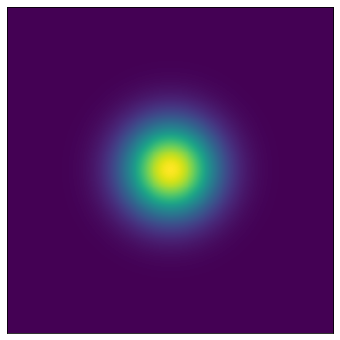

In [43]:
dist = NormalDistribution2D()
dist.plot()

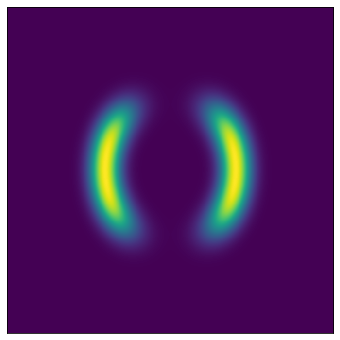

In [44]:
dist1 = TargetDistribution1()
dist1.plot()

# Define Model Architecture

When we stuck the same layer, we use nn.Modulelist.


$$
\begin{eqnarray}
    \log q_k(\mathbf{z}_k) &=& \log q_0(z_0) + \sum^K_{k=1} \log |\mathrm{det} J_k|^{-1}, \\
     &=& \log q_0(z_0) - \sum^K_{k=1} \log |1 + \mathbf{u}^T_k \psi_k(\mathbf{z}_{k-1})|
\end{eqnarray}
$$

- Loss function

We can write loss function (ELBO) $\mathcal{F}(\mathbf{x})$ as

$$
\begin{eqnarray}
    \mathcal{F}(\mathbf{x}) &=& \mathbb{E}_{q_0} [\log q_k(\mathbf{z}_k) - \log p(\mathbf{x}, \mathbf{z}_k)] \\
    &=& \mathbb{E}_{q_0} [ \log q_0(z_0) - \sum^K_{k=1} \log |1 + \mathbf{u}^T_k \psi_k(\mathbf{z}_{k-1})| - \log p(\mathbf{x}, \mathbf{z}_k)]
\end{eqnarray}
$$

In [384]:
class PlanarFlow(nn.Module):
    
    def __init__(self, dim):
        super(PlanarFlow, self).__init__()
        self.h = lambda x: torch.tanh(x)
        self.h_prime = lambda x: 1 - torch.tanh(x) ** 2

        # Initialize the parameters with normal distribution
        # If init_sigma is too small, flow cannot generate the bimodal distribution.
        self.init_sigma = 1
        self.weights = nn.Parameter(torch.randn(1, dim).normal_(0, self.init_sigma))
        self.u = nn.Parameter(torch.randn(1, dim).normal_(0, self.init_sigma))
        self.bias = nn.Parameter(torch.randn(1).fill_(0))
    
        """
        # Initialize the parameters with uniform distribution
        uni = torch.distributions.uniform.Uniform(torch.tensor([-1.5]), torch.tensor([1.5]))
        self.weights = nn.Parameter(uni.sample((dim,)).t())
        self.u = nn.Parameter(uni.sample((dim,)).t())
        self.bias = nn.Parameter(uni.sample())
        """

    def forward(self, x):

        z, log_q = x
        
        # Modification of u to have inverse transformation w^T * u >= -1      
        inner_wu = (self.weights @ self.u.t()).squeeze()
        u_hat = self.u + ( (-1 + torch.log1p(inner_wu.exp())) - inner_wu) * (self.weights / (self.weights @ self.weights.t()))

        z = z + u_hat * self.h( z @ self.weights.t() + self.bias )
        psi = self.h_prime (z @ self.weights.t() + self.bias) * self.weights
        det_jacob = torch.abs(1 + u_hat @ psi.t())
        log_q -= torch.log(det_jacob + 1e-7).squeeze()
        
        return z, log_q

In [385]:
class NormalizingFlow(nn.Module):
    
    def __init__(self, dim, K):
        
        super(NormalizingFlow, self).__init__()
        
        self.dim = dim
        self.K = K
        self.flows = torch.nn.ModuleList()
        for k in range(K):
            self.flows.append(PlanarFlow(dim))
        
    def forward(self, z, log_q):
        # Flow calculation
        for flow in self.flows:
            z, log_q = flow((z, log_q))
            
        return z, log_q

# Loss Function

$$
\begin{eqnarray}
    \mathcal{F}(\mathbf{x}) = \mathbb{E}_{q_0} [\log q_k(\mathbf{z}_k) - \log p(\mathbf{x}, \mathbf{z}_k)]
\end{eqnarray}
$$

**なぜ結合分布P(x,z_k)が以下のように計算されるのか？？**

In [387]:
def calc_loss(z_k, log_q_k, target_density):
    log_p = torch.log(target_density.calc_prob_torch(z_k)+1e-7)
    loss = torch.mean(log_q_k - log_p).squeeze()
    return loss

# Training

In [398]:
import torch.optim as optim
from torch.distributions import multivariate_normal

# optimizer = optim.Adam(nflow.parameters(), lr=0.01)
optimizer = torch.optim.RMSprop(nflow.parameters(), lr=1e-2, momentum=0.9, alpha=0.90, eps=1e-6)

In [399]:
#  Distribution of the latent variable
standard_normal_2d = multivariate_normal.MultivariateNormal(torch.zeros(2), torch.eye(2))
traget_density = TargetDistribution1()

In [444]:
def train_flow(flow, 
    lr_decay = 0.999,
    log_interval = 2000,
    iterations = 20000,
    batch_size = 100, ):
    
    z_dimension = 2
    K = 32

    nflow = NormalizingFlow(dim=z_dimension, K=K)

    cur_path = os.getcwd()
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)

    # anneal rate for free energy
    # temp = lambda i: min(1, 0.01 + i/10000)
    
    running_loss = 0
    for i in range(1, iterations + 1):

        scheduler.step()

        # Sample z_0, log_q_0
        z_0 = standard_normal_2d.sample([batch_size])
        log_q_0 = standard_normal_2d.log_prob(z_0)
        
        z_k, log_q_k = flow(z_0, log_q_0)
        optimizer.zero_grad()
        loss = calc_loss(z_k, log_q_k, target_density=traget_density)
        loss.backward()
        optimizer.step()

        # print learing process
        running_loss += loss.item()
        if i % log_interval == 0:
            print('[%5d] loss: %.3f' %
                  (i, running_loss / log_interval))
            running_loss = 0.0
            
            # save model
            torch.save({'step': i,
                        'flow_state': nflow.state_dict(),
                        'optimizer_state': optimizer.state_dict()},
                        os.path.join(cur_path, 'model_flow_length_{}.pth'.format(K)))

            # plot and save results
            with torch.no_grad():
                plot_flow(standard_normal_2d, nflow, os.path.join(cur_path, 'approximating_flow_step{}.png'.format(i)))

In [445]:
def plot_flow(base_dist, nflow, filename):
    
    lim = 4

    # plot flow-transformed base dist sample and histogram
    z_0 = base_dist.sample([200000,])
    log_q_0 = base_dist.log_prob(z_0)
    z_k = nflow(z_0, log_q_0)[0].data.numpy()
    
    plt.figure(figsize=(6, 6))
    plt.hist2d(z_k[:,0], z_k[:,1], bins=4*50, cmap=plt.cm.jet)
    plt.savefig(filename)
    plt.show()
    plt.close()

[ 2000] loss: -1.099


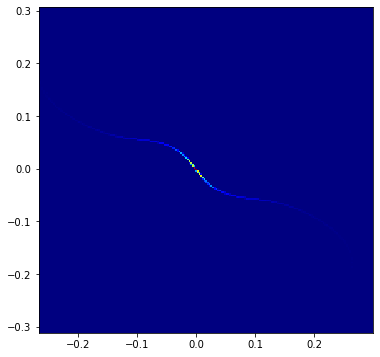

[ 4000] loss: -1.452


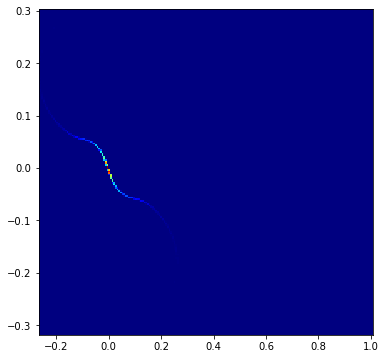

[ 6000] loss: -1.610


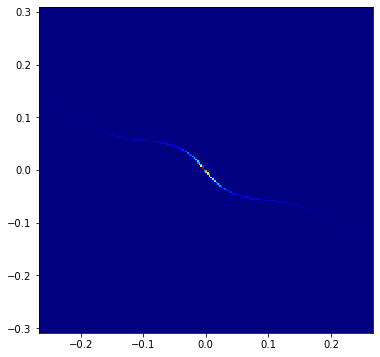

KeyboardInterrupt: 

In [446]:
train_flow(nflow)

# Check the results

- We can observe half moon for several settings. This happens for small **init_sigma=[0.01, 0.05, 0.5]**.
For *init_sigma =1*, we can obserbe
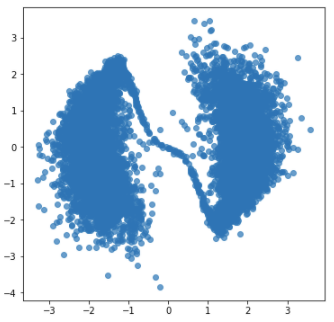

Related Issue is https://github.com/casperkaae/parmesan/issues/22. According to a discussion on the page, 

> I wrote an email to Rezende about this and he kindly confirmed that this is in fact a pretty tricky optimization problem and that the parameters > should be initialized by drawing from a normal distribution with small variance (ie. the transforms start out close to the identity map).

I think *small* is not correct but $large$,

Uniform [-1.5, 1.5], K=32

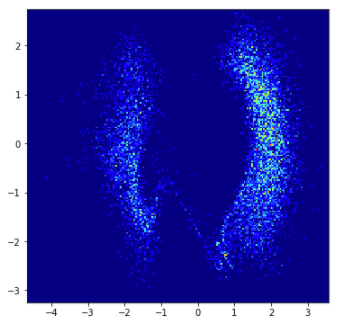

In [447]:
z_0 = standard_normal_2d.sample([100000])
log_q_0 = standard_normal_2d.log_prob(z_0)
z_k = nflow(z_0, log_q_0)[0].data.numpy()

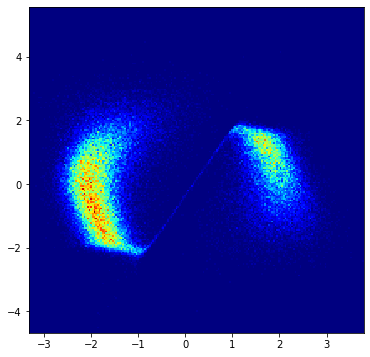

In [448]:
plt.figure(figsize=(6, 6))
plt.hist2d(z_k[:,0], z_k[:,1], bins=4*50, cmap=plt.cm.jet)
plt.show()

## Plot resuls

# Reference

- https://github.com/kamenbliznashki/normalizing_flows

Japanese

- [RealNVP](https://qiita.com/cross32768/items/87036cc35c5367050b04)